# Overview

For an autonomous vehicle, being able to detect other nearby vehicles is a must. In this project I develop a pipeline that utilizes computer vision to identify vehicles in images from a vehicle's front-facing camera. While this pipeline focues solely on identification, the next steps would be to utilize the information to predict relative vehicles positions and future behavior.

First, the necessary imports.

In [1]:
import cv2
import numpy as np
import glob
import time
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

These are some helpful plotting functions I like to use - simple to remember and cuts down on code.

In [2]:
def side_by_side_plot(im1, im2, im1_title=None, im2_title=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(im1)
    if im1_title: ax1.set_title(im1_title, fontsize=30)
    ax2.imshow(im2)
    if im2_title: ax2.set_title(im2_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

def big_plot(img):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(img)

## What is a car?
#### Feature Extraction

To find cars in an image, you have to have some idea of what you are looking for; you have to have some "model" of a car to which you can compare. Since an image is purely pixel values, all information drawn must ultimately come from those values. But we can get creative! I'll call extracted information from these pixels values "features." Let's see what kind of features we can come up with.


### Spatial Features

Spatial featuers are the simplest to gather but also the least useful. In the method `get_bin_spatial_features` below, you'll see all that happens is a resizing of the image and then a "flattening" with the `ravel` call. Thus, spatial features represent the values and ordering of the pixels themselves.

Image size is the only paramater to tune for extracting spatial features. I found that a 16x16 pixel image was the smallest I could go while still capturing useful information. I passed RGB images into this method, unlike the other methods which use HSV (more on this in the next section).


### Color Histogram Features

If spatial features identify the *spacing* (hence "spatial") of color values, the color histogram features identify the *amount* of certain color values. For example, you could have a color histogram that totals the number of blue, yellow, and red pixels in an image, providing a sort of color-signature.

Now most images come in the RGB color space (measuring red, green, and blue color values per pixel), which poses a problem. Identifying a vehicle as a vehicle because it has a lot of red wouldn't be accurate. But there are other color spaces, like HSV (Hue, Saturation, and Value). Identifying a vehicle by its HSV signature is much more useful and tells us things like "there's a lot of color-edges, especially in a rough box-like shape." That sounds more like a statement about a generic vehicle instead of a specific one!

The method `get_color_hist_features` will do this work for us. The only real parameter to tune for extracting color histogram features is the number of bins or "buckets" you want to divide the color space into. 16 bins ended up being not enough specificity, and 64 was too much. I ended up passing in HSV images and separating the color space into 32 bins.


### HOG Features

Finally, HOG features are not only the most interestingly named but also the most useful of the features we gather (and the most computationally expensive). HOG stands for "histogram of oriented gradients," and can basically be thought of as "colors are changing by x amount in y direction" (hence "oriented gradients").

The HOG features will be the bulk of the vehicle signature, and they excel at providing generic shape information - exactly what we need! The method `get_hog_features` will extract these features for us.

There are more parameters to tune when extracting HOG features compared to other feature-extraction methods: the number of orientation directions, pixels-per-cell, and cells-per-block. While 9 orientation directions is commonly used, I found that 8 (think cardinal directions) provided the same performance and required less data. 8 pixels-per-cell and 8 cells-per-block performed well and fit perfectly with the 64x64 pixel training images, so I didn't toy with those settings much.


#### The Code

In the code below a function is created to extract each feature-set. These are combined into a larger `extract_features` method that will call the individual feature-set-extracting methods and combine them into a single feature-signature for the image.

In [3]:
# Returns binned color features for an image
def get_bin_spatial_features(img, size=(16, 16)):
    # Resize the image, and then flatten it out into a feature vector
    return cv2.resize(img, size).ravel()


# Returns the color histogram features for an image
def get_color_hist_features(img, nbins=32, bins_range=(0, 256)):
    ''' NEED TO CHANGE bins_range if reading .png files with mpimg! '''
    
    # Compute the histogram of the color channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)[0]
    ch2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)[0]
    ch3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)[0]
    
    # Concatenate the histograms into a single feature vector
    return np.concatenate((ch1_hist, ch2_hist, ch3_hist))


# Return HOG features and visualization for an image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:  # Call with two outputs if vis==True
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# This function will take a list of img file names and turn it into a list of image features for the classifier
def extract_features(imgs, color_space='HSV', spatial_size=(16,16), hist_bins=32,
                     orient=8, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', precomputed_hog=None,
                     use_spatial_features=True, use_color_hist_features=True, use_hog_features=True):
    ''' "imgs" can be paths OR loaded images '''
    
    features = []  # List to append feature vectors to
    for img in imgs:
        img_features = []
        if type(img) is str:
            image = mpimg.imread(img)
            if img.endswith('.png'):
                image = image*255
        else:
            image = img
            
        img_size = (64, 64)
        if image.shape[:2] != img_size:
            image = cv2.resize(image, img_size)
        if precomputed_hog is not None and precomputed_hog.shape[:2] != img_size:
            precomputed_hog = cv2.resize(precomputed_hog, img_size)
        
        # Color Conversion
        original_image = np.copy(image)
        if color_space == 'RGB':
            image = np.copy(image)
        else:
            color = eval('cv2.COLOR_RGB2{}'.format(color_space))
            image = cv2.cvtColor(image, color)

        # Spatial Features
        if use_spatial_features == True:
            spatial_features = get_bin_spatial_features(original_image, size=spatial_size)
            img_features.append(spatial_features)
            
        # Color Histogram Features
        if use_color_hist_features == True:
            hist_features = get_color_hist_features(image, nbins=hist_bins)/255
            img_features.append(hist_features)
            
        # HOG Features
        if use_hog_features == True:
            if precomputed_hog is not None:
                img_features.append(precomputed_hog*255)
            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(image.shape[2]):
                        hog_features.append(get_hog_features(
                            image[:,:,channel], 
                            orient,
                            pix_per_cell,
                            cell_per_block, 
                            vis=False,
                            feature_vec=True
                        ))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(
                        image[:,:,hog_channel],
                        orient, 
                        pix_per_cell,
                        cell_per_block,
                        vis=False,
                        feature_vec=True
                    )

                img_features.append(hog_features*255)
            
        # Add this image's features to the master list
        features.append(np.concatenate(img_features))
        
    if len(imgs) == 1:
        return np.array(features)
    
    return features

## Using the Features
#### Training a Classifier

With a way to extract the desired features from an image, it's time to use those features to train a machine-learning classifier to identify a vehicle.

In the code below features are extracted from 17,760 images, about half containing vehicles and half not containing vehicles. These features are labeled as "0" or "1" (vehicle or non-vehicle) and passed into a Support Vector Machine that linearly separates the data.

Each image's 5,568 feature values are normalized before being passed in to improve learning. In the code output below you'll see a randomly selected image along with a graph of its original and normalized feature values.

We end up with a 99.1% test accuracy - pretty good!

Extracting features from 17760 images...
Took 85.71 seconds to extract 17760 image features
Training the SVC...
Took 12.65 seconds to train the SVC...
Test accuracy of the SVC: 0.993


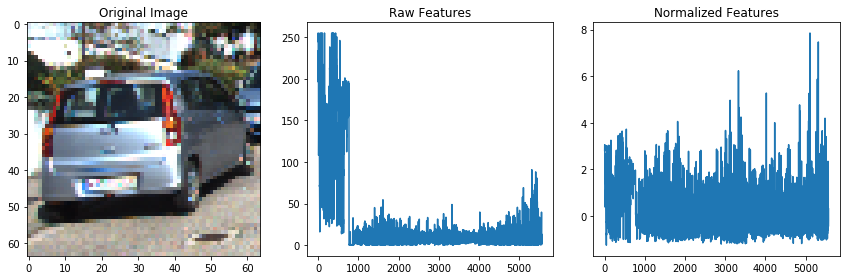

In [4]:
vehicle_img_paths = shuffle(glob.glob('./vehicles/*/*.png'))#[:500]
nonvehicle_img_paths = shuffle(glob.glob('./non-vehicles/*/*.png'))#[:500]

n_imgs = len(vehicle_img_paths) + len(nonvehicle_img_paths)

# Extract vehicle and non-vehicle image features
print('Extracting features from {} images...'.format(n_imgs))
t = time.time()
vehicle_features = extract_features(vehicle_img_paths)
nonvehicle_features = extract_features(nonvehicle_img_paths)

t2 = time.time()
print('Took', round(t2-t, 2), 'seconds to extract', n_imgs, 'image features')

x = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)
scaler = StandardScaler().fit(x)
scaled_x = scaler.transform(x)  # Normalize the features
# Labels vector - 1 is car, 0 is not
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))

# These values are used later to cap absurd scaling - weird error
min_scaled = np.min(scaled_x)
max_scaled = np.max(scaled_x)

# Shuffle and train/test split
rand = random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.25, random_state=rand)

# Train the SVC
print('Training the SVC...')
svc = LinearSVC()
t = time.time()  # Track the training time
svc.fit(x_train, y_train)
t2 = time.time()
print('Took', round(t2-t, 2), 'seconds to train the SVC...')

# Measure SVC accuracy
print('Test accuracy of the SVC:', round(svc.score(x_test, y_test), 3))

# Plot an example of raw and scaled features
car_ind = random.randint(0, len(vehicle_img_paths))
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(vehicle_img_paths[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(x[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_x[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## Using the SVM
#### Finding Cars in a New Image

So we have a super-smart SVM classifier - now what? Unfortunately we can't just pass in a whole front-facing vehicle camera image to it and expect cars to magically be identified. The SVM was trained on nicely-cropped 64x64 pixel images. We need to find a way to feed it similar input if we want that nice 99.1% accuracy output.

We'll do this through a brute-force search using sliding windows. Windows of various sizes will be passed over parts of the image to capture many sub-images. Each of these sub-images will then be tested with the classifier to tell us whether the sub-image contains a car or not.

Below I create the `get_windows` function to perform the "sliding-window" technique. This function doesn't return the sub-images but rather the many window coordinates. The sub-images will be extracted and tested later.

In the output below you see the many windows drawn onto the image. A high 75% overlap is used to avoid missing centered images of the vehicles. The smaller red windows are restricted to a smaller area at the top of the road, since small vehicle images won't be appearing close by. Also, to reduce computation time, I only search the right half of the image because the pictures are taken from a vehicle in the far-left lane. In a production pipeline the full x-axis would need to be searched or logic would need to be implemented to determine what portion of the x-axis to search.

542 windows


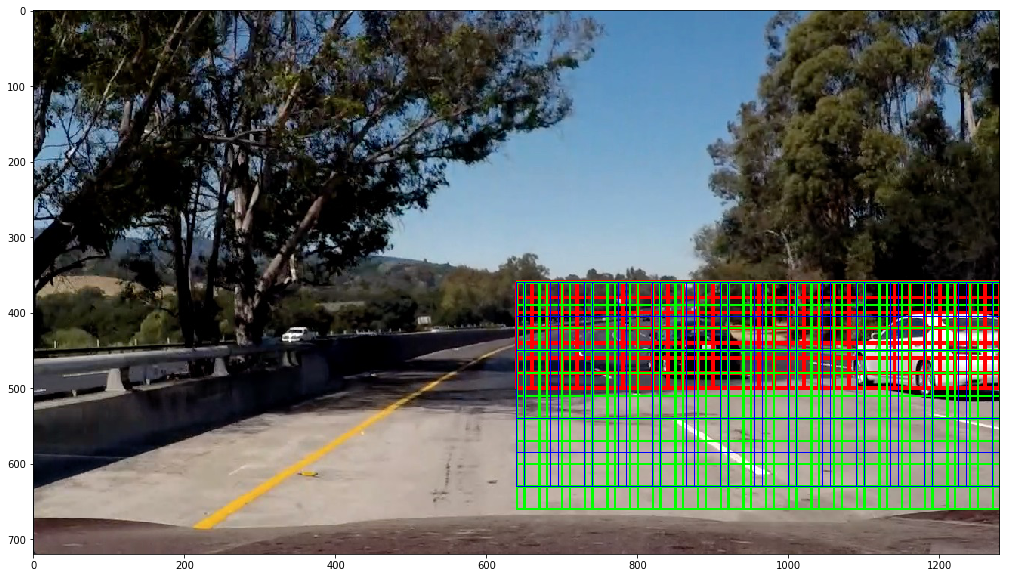

In [10]:
# Returns the list of windows to search through and the still-shaped hog for the entire image
def get_windows(img, sizes=[128, 180, 256], overlap=.75, y_start_stop=(.5, .92), x_start_stop=(.5, 1)):
    ''' "sizes" are the square dimensions of the windows we will tile
        "y_start_stop" and "x_stop_stop" are passed in as percentages of the image '''
    
    y_size, x_size = img.shape[:2]
    
    x_start = int(x_start_stop[0]*x_size)
    x_stop = int(x_start_stop[1]*x_size)
    y_start = int(y_start_stop[0]*y_size)
    y_stop = int(y_start_stop[1]*y_size)
    
    windows = []  # windows will be stored in this array as a tuple of tuples representing top-left and bottom-right window coordinates
    for size in sizes:
        step = int(size*(1-overlap))
        for y in range(y_start, y_stop-size, step):
            for x in range(x_start, x_stop-size, step):  # Windows tiled from the left
                windows.append(((x, y), (x+size, y+size)))
            for x in range(x_stop, x_start+size, -step):  # Windows tiled from the right
                windows.append(((x-size, y), (x, y+size)))
               
    return windows
    
    
# Draws bounding boxes
def draw_boxes(img, boxes, color=(0, 0, 255), thickness=4):
    imcopy = np.copy(img)
    for box in boxes:
        cv2.rectangle(imcopy, box[0], box[1], color, thickness)
        
    return imcopy


image = mpimg.imread('./test_images/test5.jpg')
draw_img = np.copy(image)
boxes_1 = get_windows(image, sizes=[80], y_start_stop=(.5, .7))
boxes_2 = get_windows(image, sizes=[120])
boxes_3 = get_windows(image, sizes=[180])
draw_img = draw_boxes(draw_img, boxes_1, color=(255, 0, 0), thickness=3)
draw_img = draw_boxes(draw_img, boxes_2, color=(0, 255, 0), thickness=2)
draw_img = draw_boxes(draw_img, boxes_3, color=(0, 0, 255), thickness=1)
# windows = np.concatenate((boxes_1))
# windows = np.concatenate((boxes_1, boxes_2))
windows = np.concatenate((boxes_1, boxes_2, boxes_3))
print(len(windows), 'windows')
# draw_img = draw_boxes(draw_img, windows)
big_plot(draw_img)

## Which Windows are Good?
#### Drawing Bounding-Boxes on the Vehicles

The sliding-window method above results in 542 windows. That's a lot! Each of these windows, these sub-images, will be tested by extracting features and passing those features to the classifier using the `contains_car` method. In the end, the windows that are left tell us roughly where the vehicles are (see the left output image below). Out of the original 542 windows we are left with around 4 for the black car, and about 10 for the white car. But we're looking for a single bounding-box per vehicle - this won't do.

To reach a single bounding-box per vehicle I utilize a heatmap. Where windows overlap, the region gets "hotter." The heatmap identifies high concentrations of windows. In `get_heatmap` the good windows are used to build a heatmap the same size as the original image. `threshold_heatmap` filters out areas that aren't "hot" enough (didn't have enough windows saying a vehicle was present there). Finally, `draw_heatmap_boxes` takes the original image and its heatmap to draw boxes around the "hot" areas.

As you can see in the right output image, using the heatmap information allows us to draw a single bounding-box around each car - exactly what we wanted!

542 windows


True

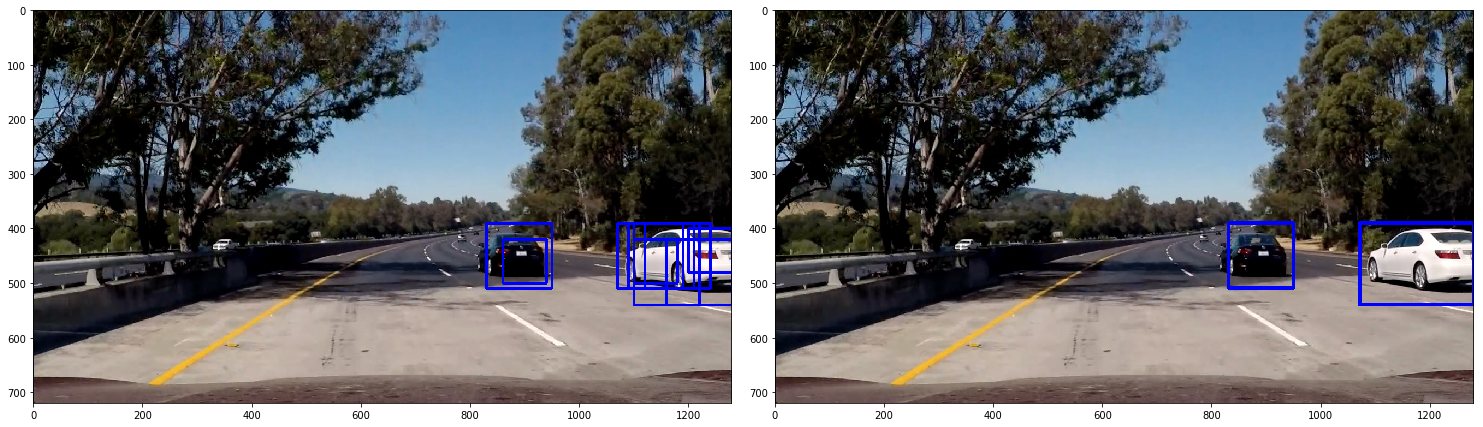

In [15]:
# Returns boolean for whether the window of the given image contains a car
def contains_car(img, window):
    top_left, bottom_right = window[0], window[1]
    sub_img = img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    
    features = extract_features([sub_img])
    scaled_features = scaler.transform(features)  # Normalize the features
    scaled_features = np.clip(scaled_features, min_scaled, max_scaled)  # Was getting a single HUGE value, so clipping
    
    return svc.predict(scaled_features) == 1
    

def get_heatmap(img, boxes, thresholded=False):
    heatmap = np.zeros_like(img[:,:,0])
    for box in boxes:
        top_left, bottom_right = box[0], box[1]
        heatmap[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] += 1
    
    if thresholded: return threshold_heatmap(heatmap)
    
    return heatmap


def threshold_heatmap(heatmap, threshold=2):
    heatmap[heatmap < threshold] = 0
    return heatmap


def get_aggregate_heatmap(thresholded=True, threshold=4):
    global prev_heatmaps
    
    heatmaps = np.array(prev_heatmaps)
    
    if not thresholded: return np.sum(heatmaps, axis=0)
    
    return threshold_heatmap(np.sum(heatmaps, axis=0), threshold=threshold)


def draw_heatmap_boxes(img, heatmap):
    label_img, n_items = label(heatmap)
    # Iterate through all detected cars
    for car_number in range(1, n_items+1):
        # Find pixels with each car_number label value
        nonzero = (label_img == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, box[0], box[1], (0, 0, 255), 6)
        
    return img

    
image = mpimg.imread('./test_images/test5.jpg')
draw_img = np.copy(image)

windows_1 = get_windows(image, sizes=[80], overlap=.75, y_start_stop=(.5, .7))
windows_2 = get_windows(image, sizes=[120, 180], overlap=.75)
windows = windows_1 + windows_2
print(len(windows), 'windows')

car_windows = []
for window in windows:
    if contains_car(image, window):
        car_windows.append(window)
        
draw_img = draw_boxes(draw_img, car_windows)
heatmap = get_heatmap(image, car_windows, thresholded=False)
heatmap_boxes = draw_heatmap_boxes(np.copy(image), heatmap)
side_by_side_plot(draw_img, heatmap_boxes)
cv2.imwrite('./example_images/good_windows.jpg', cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR))
cv2.imwrite('./example_images/found_cars.jpg', cv2.cvtColor(heatmap_boxes, cv2.COLOR_RGB2BGR))

## Putting it All Together
#### A Single Pipeline Function

All of the steps *after* creating the classifier can be grouped together into a single function, `find_cars`. Given an image, `find_cars` will return the same image with bounding-boxes drawn around the vehicles.

#### An Aggregate Heatmap

You may have been wondering about the `get_aggregate_heatmap` function I failed to mention above. While I grouped it with the other heatmap functions, it goes unused until the `find_cars` pipeline function is established below. While the classifier is good, it's not perfect, and false positives still get through. These false positives can be avoided by summing the heatmaps across multiple frames (of a video) and taking a higher threshold. `get_aggregate_heatmap` along with the stored `prev_heatmaps` accomplishes this for us.

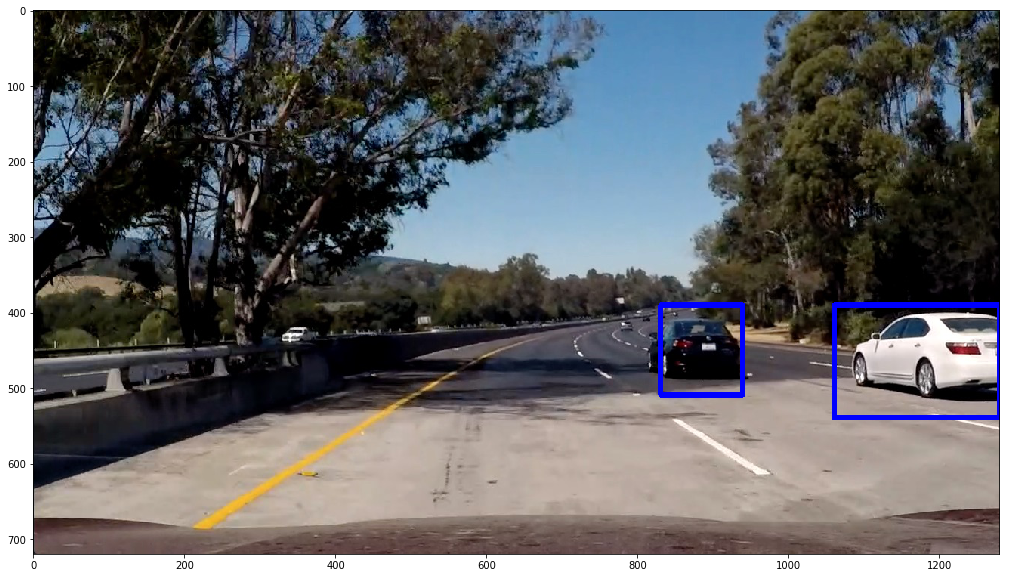

In [450]:
prev_heatmaps = []

def find_cars(image):
    global prev_heatmaps
    
    windows_1 = get_windows(image, sizes=[80], y_start_stop=(.5, .7))
    windows_2 = get_windows(image, sizes=[120, 180])
    windows = windows_1 + windows_2
    
    car_windows = []
    for window in windows:
        if contains_car(image, window):
            car_windows.append(window)
            
    heatmap = get_heatmap(image, car_windows, thresholded=False)
    prev_heatmaps.insert(0, heatmap)
    if len(prev_heatmaps) > 5:
        prev_heatmaps.pop()
    aggregate_heatmap = get_aggregate_heatmap(threshold=4)
    
    return draw_heatmap_boxes(np.copy(image), aggregate_heatmap)

image = mpimg.imread('./test_images/test5.jpg')
big_plot(find_cars(image))

### Processing Videos

The `find_cars` method above is perfect for processing the frames in a video. Each frame (each image) is passed through this pipeline, and the vehicle-detection heatmap is generated and saved. Using `get_aggregate_heatmap`, the heatmaps for the last 5 frames are summed together to give us a false-positive-guarded look at where the vehicles are. Finally, using this information, each frame has the bounding-boxes drawn and the annotated image is returned.

The code below produces a new video that is identical to the original with the exception of bounding-boxes identifying the vehicles. My `project_video.mp4` output can be viewed on YouTube here: [https://youtu.be/cFNJqk6LXj4](https://youtu.be/cFNJqk6LXj4).

In [307]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
prev_heatmaps = []

f_name = 'test_video.mp4'
video = VideoFileClip('./videos/{}'.format(f_name))  # Load the original video
video = video.fl_image(find_cars)  # Pipe the video frames through the car-detection pipeline
%time video.write_videofile('./videos_out/{}'.format(f_name), audio=False)  # Write the new video

In [ ]:
prev_heatmaps = []

f_name = 'project_video.mp4'
video = VideoFileClip('./videos/{}'.format(f_name))  # Load the original video
video = video.fl_image(find_cars)  # Pipe the video frames through the car-detection pipeline
%time video.write_videofile('./videos_out/{}'.format(f_name), audio=False)  # Write the new video

## Reflection
#### Issues and Improvements

I'll go ahead and say that **by far** the biggest problem with my pipeline is computation time. For a 50-second video it took 46 minutes to process. Not good. The bottleneck is feature-extraction. For each of the 500ish windows in each frame, three different feature-sets need to be extracted.

The most expensive feature extraction method is HOG. One way to improve performance would be to pre-compute the HOG features for each frame, and then sub-sample the HOG image for each window. HOG accounts for about half of the feature-extraction time, so that would bring a 50-second video processing down to around 23 minutes, which still isn't good.

Maybe the biggest performance-impacting factor is the number of windows searched. Instead of 500ish windows I once had around 200ish windows, and things were much quicker. Unfortunately, I needed the smaller windows to continue to track the black car as it distanced itself from the source vehicle. While restricting these small windows to the top half of the road area helped, it was still a big performance hit.

The only other issue would be the slight imperfections in the video output. There's one spot where the black car is lost for a fraction of a second, and there are some false positives that slip through once or twice. I believe better heatmap thresholding might take care of the issue, but exploring other classifiers or different classifier parameters might make the difference too.